# Explore the GPyTorch and Celerité API

We start by exploring the APIs of the two packages `GPyTorch` and `celerite`.  They are both packages for scalable Gaussian Processes with different strategies for doing the scaling.

In [1]:
import gpytorch

In [2]:
import celerite

In [3]:
gpytorch.__version__, celerite.__version__

('0.3.6', '0.3.1')

We'll need some other standard and astronomy-specific imports and configurations.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let's draw synthetic time series "data" with a Gaussian process from celerite.  This approach is useful, since we know the answer: and the kernel that generated the data and its parameter values.  We'll pick Matérn kernels, since both frameworks offer them out-of-the-box.  Technically, the celerite Matern is an approximation, but we'll be sure to make draws with parameter values where the approximation will be near-exact.

## Matérn 3/2 with celerite.

This kernel is characterized by two parameters:

$k(\tau) = \sigma^2\,\left(1+
        \frac{\sqrt{3}\,\tau}{\rho}\right)\,
        \exp\left(-\frac{\sqrt{3}\,\tau}{\rho}\right)$
  

Here are the inputs for `celerite`:


> Args:  
    - log_sigma (float): The log of the parameter :math:`\sigma`.  
    - log_rho (float): The log of the parameter :math:`\rho`.  
    - eps (Optional[float]): The value of the parameter :math:`\epsilon`.  
        (default: `0.01`)



In [5]:
from celerite import terms

In [6]:
true_rho = 1.5
true_sigma = 1.2

In [7]:
true_log_sigma = np.log(true_sigma)
true_log_rho = np.log(true_rho)  # Has units of time, so 1/f

In [8]:
kernel_matern = terms.Matern32Term(log_sigma=true_log_sigma, log_rho=true_log_rho, eps=0.00001)

In [9]:
t_vec = np.linspace(0, 40, 500)

In [10]:
gp = celerite.GP(kernel_matern, mean=0, fit_mean=True)
gp.compute(t_vec)
y_true = gp.sample()

In [11]:
noise = np.random.normal(0, 0.3, size=len(y_true))
y_obs = y_true + noise

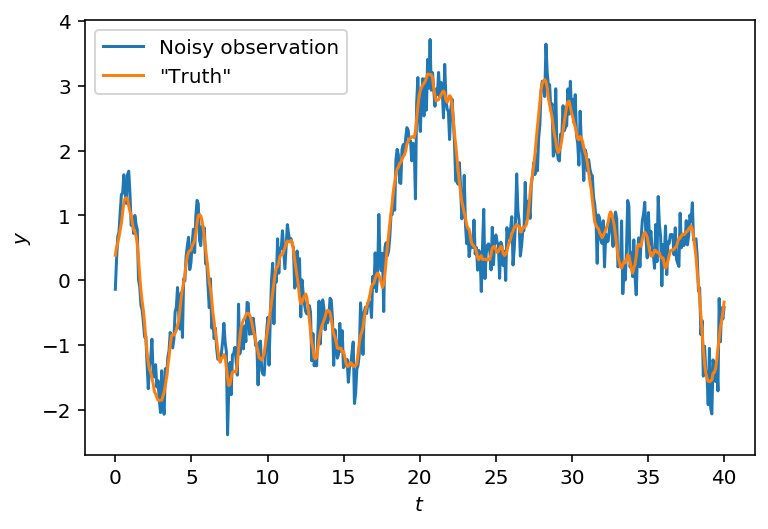

In [12]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='"Truth"')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

## Now with GPyTorch and RBF kernel

In [13]:
import torch

In [14]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

In [15]:
train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)

In [16]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Train the model.

In [17]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [18]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])

In [19]:
with gpytorch.settings.max_cg_iterations(5000):
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 300
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if (i % 20) == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.6f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.raw_lengthscale.item(),
                model.likelihood.noise.item()
            ))
            #print(list(model.parameters()))
        optimizer.step()

Iter 1/300 - Loss: 1.008   lengthscale: 0.000   noise: 0.693247
Iter 21/300 - Loss: 0.472   lengthscale: 1.580   noise: 0.131774
Iter 41/300 - Loss: 0.454   lengthscale: 1.614   noise: 0.071615
Iter 61/300 - Loss: 0.445   lengthscale: 1.663   noise: 0.095406
Iter 81/300 - Loss: 0.438   lengthscale: 1.536   noise: 0.085152
Iter 101/300 - Loss: 0.448   lengthscale: 1.470   noise: 0.088692
Iter 121/300 - Loss: 0.442   lengthscale: 1.452   noise: 0.087375
Iter 141/300 - Loss: 0.432   lengthscale: 1.442   noise: 0.087444
Iter 161/300 - Loss: 0.462   lengthscale: 1.422   noise: 0.088300
Iter 181/300 - Loss: 0.448   lengthscale: 1.442   noise: 0.087291
Iter 201/300 - Loss: 0.450   lengthscale: 1.406   noise: 0.086718
Iter 221/300 - Loss: 0.445   lengthscale: 1.398   noise: 0.087055
Iter 241/300 - Loss: 0.442   lengthscale: 1.436   noise: 0.089390
Iter 261/300 - Loss: 0.443   lengthscale: 1.518   noise: 0.088230
Iter 281/300 - Loss: 0.451   lengthscale: 1.488   noise: 0.087003


### How did it do?

In [20]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(9000):
    test_x = torch.linspace(0, 40, 501, dtype=torch.float32)
    observed_pred = likelihood(model(test_x))

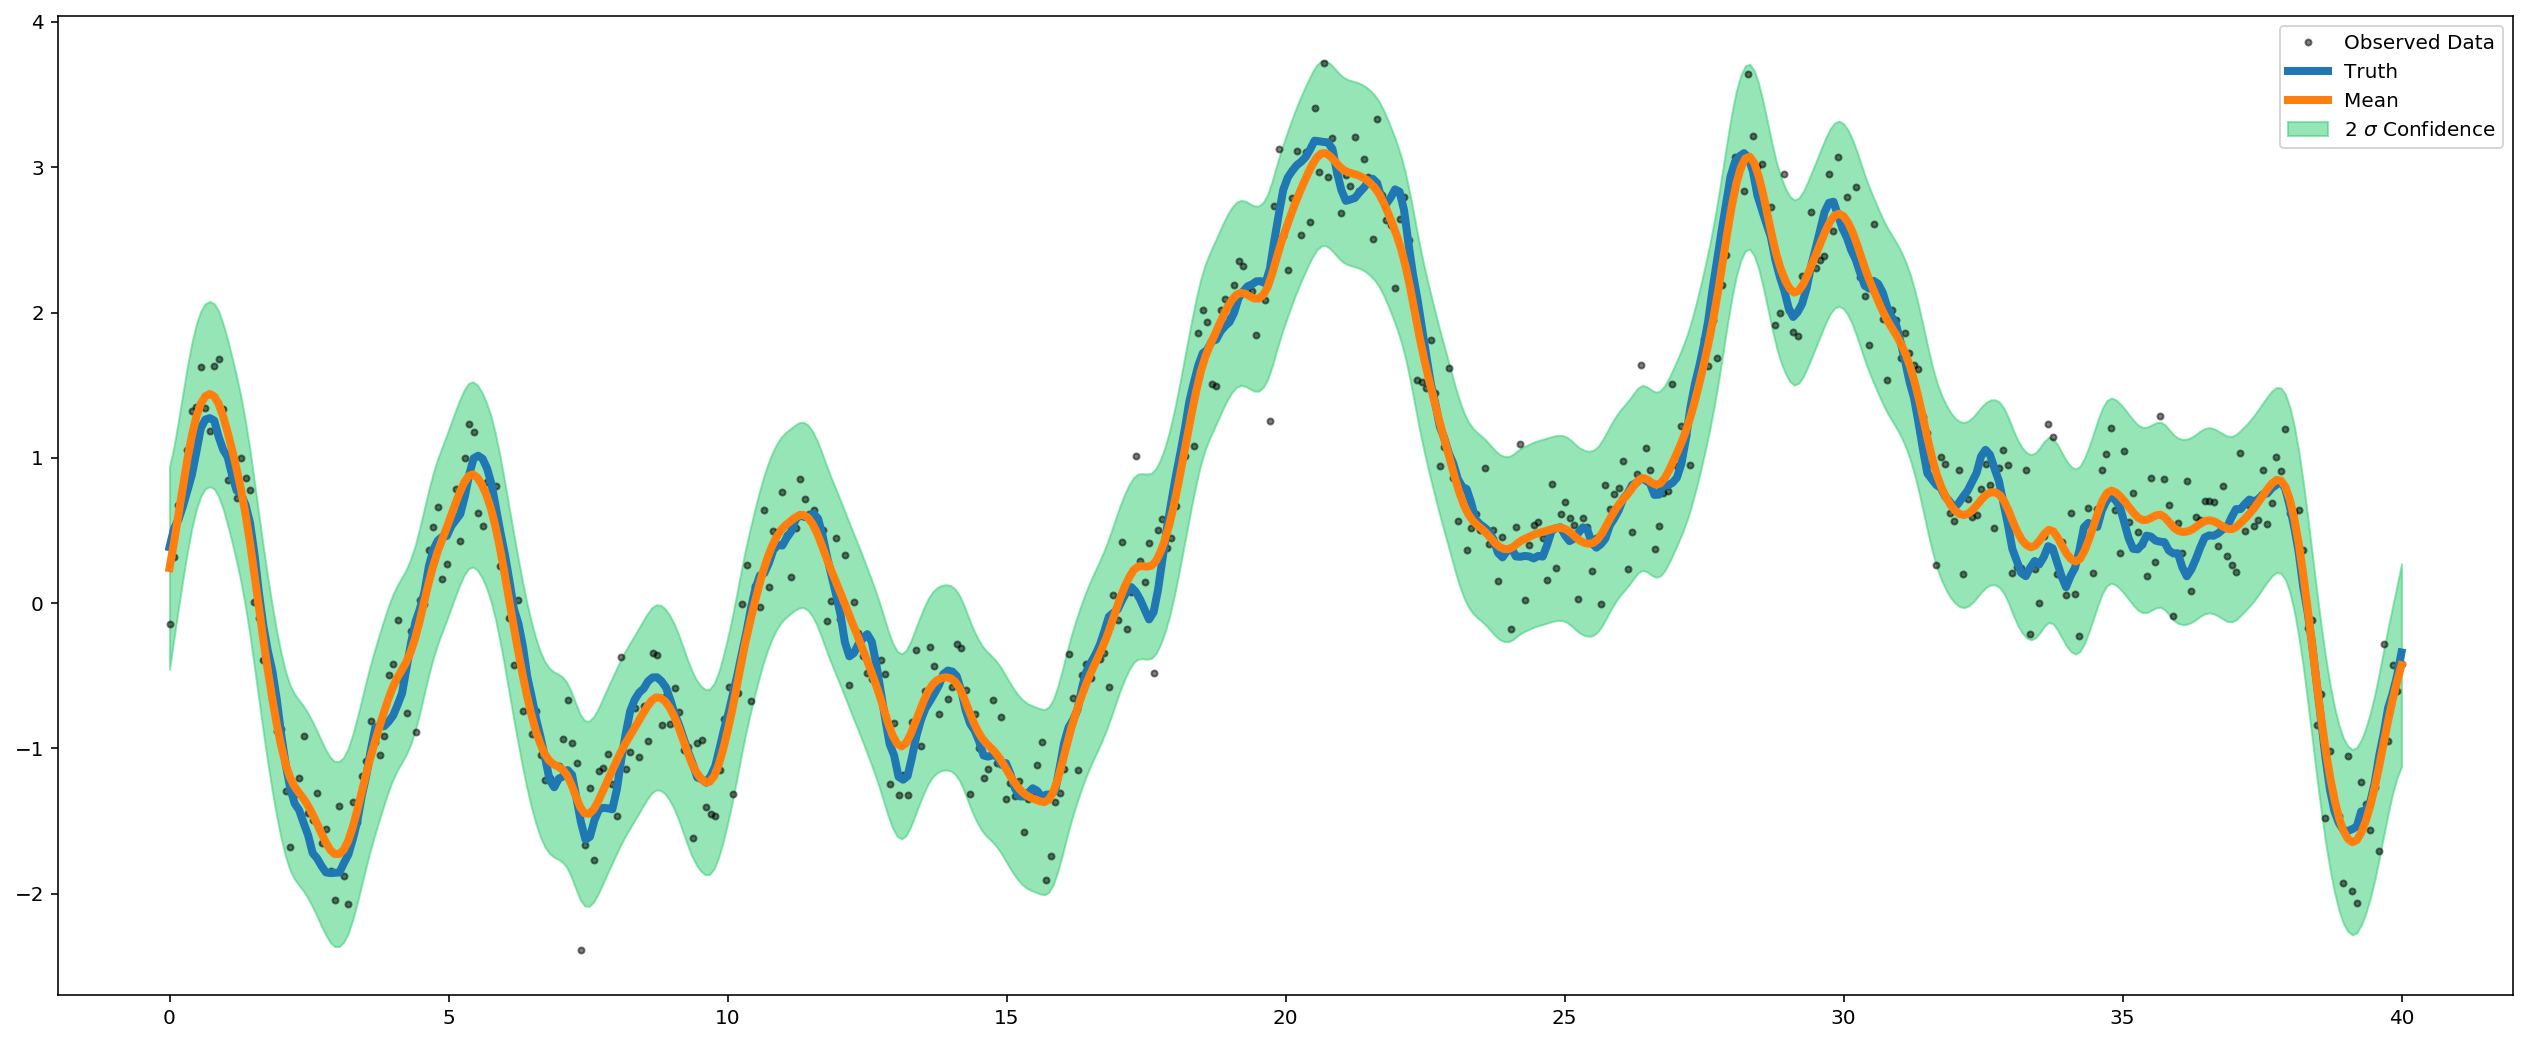

In [21]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(22, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k.', alpha=0.5)
    # Plot predictive means as blue line
    ax.plot(t_vec, y_true, lw=4)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), lw=4)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    ax.legend(['Observed Data', 'Truth', 'Mean', '2 $\sigma$ Confidence'])

Nice!

What are the four parameters?

In [22]:
model.mean_module.constant

Parameter containing:
tensor([0.3822], requires_grad=True)

In [23]:
likelihood.raw_noise

Parameter containing:
tensor([-2.3927], requires_grad=True)

In [24]:
model.covar_module.raw_outputscale

Parameter containing:
tensor(1.3181, requires_grad=True)

In [25]:
model.covar_module.base_kernel.raw_lengthscale

Parameter containing:
tensor([[1.4946]], requires_grad=True)